In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from corner import corner
from functools import partial

import dynesty
import dynesty.plotting as dyplot

from thesis.io import gyre, fgong
from thesis.physics import sound_speed, acoustic_depth
from thesis.calculus import differentiate
from thesis.glitch import GlitchModel, GlitchPrior, estimate_asy
from thesis.samplers import NestedSampler

import jax
import jax.numpy as jnp
from jax import random, tree_util
from jax.scipy.stats import norm, uniform
jax.config.update("jax_enable_x64", True)

import tinygp
from tinygp import kernels, GaussianProcess

rng = random.PRNGKey(0)

In [2]:
root_path = os.path.expanduser("~/OneDrive/Data/MESA/solar_models/y0.28/")
profile_name = "profile"

filename = os.path.join(root_path, ".".join([profile_name, "data", "FGONG"]))
gong = fgong.load_fgong(filename)
gong

<xarray.Dataset>
Dimensions:       (x: 1046)
Coordinates:
  * x             (x) float64 0.0 0.0009072 0.001143 ... 1.001 1.001 1.001
Data variables: (12/36)
    r             (x) float64 0.0 6.399e+07 8.063e+07 ... 7.062e+10 7.062e+10
    ln_q          (x) float64 -708.4 -16.36 -15.67 -14.98 ... 0.0 0.0 0.0 0.0
    T             (x) float64 1.549e+07 1.549e+07 ... 4.78e+03 4.78e+03
    P             (x) float64 2.22e+17 2.22e+17 2.22e+17 ... 95.79 93.64 91.76
    rho           (x) float64 141.5 141.5 141.5 ... 2.945e-10 2.885e-10
    X             (x) float64 0.3762 0.3762 0.3762 ... 0.7304 0.7304 0.7304
    ...            ...
    X_Li7         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_Be7         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_N15         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_O17         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_O18         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_Ne20        (x) float64 0.002143 0.002143 0.002143 ... 0.001851 0.001851
Attributes: (12/15)
    M:               1.9884098706980504e+33
    R:               70538857450.55437
    L:               3.695049456876695e+33
    initial_Z:       0.02
    initial_X:       0.7
    alpha_MLT:       1.9
    ...              ...
    lambda_surf:     0.0
    d2lnPc_dlnr2:    -125.502754776413
    d2lnrhoc_dlnr2:  -163.89137578671765
    star_age:        4073344465.7814794
    Teff:            5681.793600417881
    G:               6.6743e-08

In [3]:
summary_filename = os.path.join(root_path, profile_name, "summary.h5")
detail_filenames = glob(os.path.join(root_path, profile_name, "detail*"))

pulse = gyre.load_output(summary_filename, detail_filenames)
pulse

<xarray.Dataset>
Dimensions:  (n_pg: 36, l: 3, x: 1046)
Coordinates:
  * n_pg     (n_pg) int64 1 2 3 4 5 6 7 8 9 10 ... 27 28 29 30 31 32 33 34 35 36
  * l        (l) int64 0 1 2
  * x        (x) float64 0.0 0.0009072 0.001143 0.00144 ... 1.001 1.001 1.001
Data variables:
    E_norm   (n_pg, l) float64 0.005267 nan 0.002007 ... 8.809e-09 nan nan
    freq     (n_pg, l) complex128 (255.42893986791924+0j) ... (nan+nanj)
    omega    (n_pg, l) complex128 (2.6099776215242243+0j) ... (nan+nanj)
    As       (x, n_pg, l) float64 0.0 nan 0.0 0.0 ... 2.331e+03 nan nan
    V_2      (x, n_pg, l) float64 125.5 nan 125.5 125.5 ... 5.896e+03 nan nan
    c_1      (x, n_pg, l) float64 0.009557 nan 0.009557 ... 1.003 nan nan
    xi_h     (x, n_pg, l) complex128 0j (nan+nanj) 0j ... (nan+nanj) (nan+nanj)
    xi_r     (x, n_pg, l) complex128 0j (nan+nanj) 0j ... (nan+nanj) (nan+nanj)
Attributes:
    freq_units:  UHZ
    label:

In [4]:
data = gong.merge(pulse, combine_attrs="drop_conflicts")
data

<xarray.Dataset>
Dimensions:       (x: 1046, n_pg: 36, l: 3)
Coordinates:
  * x             (x) float64 0.0 0.0009072 0.001143 ... 1.001 1.001 1.001
  * n_pg          (n_pg) int64 1 2 3 4 5 6 7 8 9 ... 28 29 30 31 32 33 34 35 36
  * l             (l) int64 0 1 2
Data variables: (12/44)
    r             (x) float64 0.0 6.399e+07 8.063e+07 ... 7.062e+10 7.062e+10
    ln_q          (x) float64 -708.4 -16.36 -15.67 -14.98 ... 0.0 0.0 0.0 0.0
    T             (x) float64 1.549e+07 1.549e+07 ... 4.78e+03 4.78e+03
    P             (x) float64 2.22e+17 2.22e+17 2.22e+17 ... 95.79 93.64 91.76
    rho           (x) float64 141.5 141.5 141.5 ... 2.945e-10 2.885e-10
    X             (x) float64 0.3762 0.3762 0.3762 ... 0.7304 0.7304 0.7304
    ...            ...
    omega         (n_pg, l) complex128 (2.6099776215242243+0j) ... (nan+nanj)
    As            (x, n_pg, l) float64 0.0 nan 0.0 0.0 ... 2.331e+03 nan nan
    V_2           (x, n_pg, l) float64 125.5 nan 125.5 ... 5.896e+03 nan nan
    c_1           (x, n_pg, l) float64 0.009557 nan 0.009557 ... 1.003 nan nan
    xi_h          (x, n_pg, l) complex128 0j (nan+nanj) ... (nan+nanj)
    xi_r          (x, n_pg, l) complex128 0j (nan+nanj) ... (nan+nanj)
Attributes: (12/17)
    M:               1.9884098706980504e+33
    R:               70538857450.55437
    L:               3.695049456876695e+33
    initial_Z:       0.02
    initial_X:       0.7
    alpha_MLT:       1.9
    ...              ...
    d2lnrhoc_dlnr2:  -163.89137578671765
    star_age:        4073344465.7814794
    Teff:            5681.793600417881
    G:               6.6743e-08
    freq_units:      UHZ
    label:

In [5]:
data["cs"] = sound_speed(data.Gamma_1, data.P, data.rho)
data["tau"] = acoustic_depth(data.r, data.cs)
tau0 = data["tau"].max()
nu0 = 5e5 / tau0
print(f"Acoustic radius is {tau0:.2f} s")
print(f"Characteristic frequency is {nu0:.2f} uHz")

Acoustic radius is 3710.25 s
Characteristic frequency is 134.76 uHz


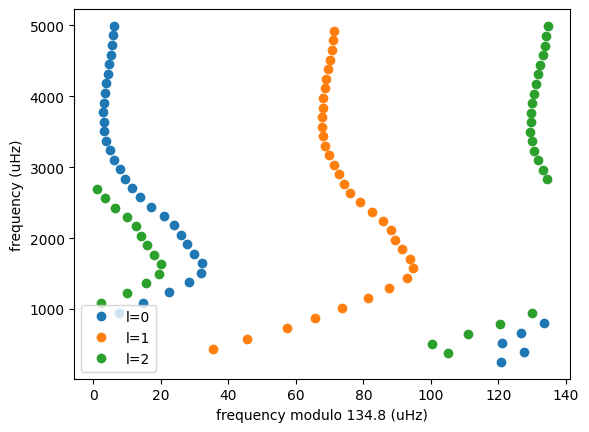

In [6]:
fig = plt.figure()

freq_mod = data.freq.real%nu0
for j in data.l:
    plt.plot(freq_mod.sel(l=j), data.freq.real.sel(l=j), 'o', color=f'C{j:d}', label=f'l={j:d}')
#     plt.plot(freq_mod.sel(l=j)-nu0, ds.freq.real.sel(l=j), 'o', color=f'C{j:d}')

plt.xlabel(f'frequency modulo {nu0:.1f} (uHz)')
plt.ylabel('frequency (uHz)')
plt.legend();

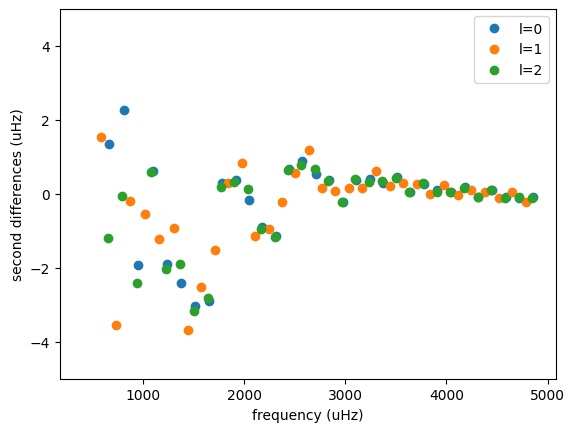

In [7]:
plt.figure()

d2nu = data.freq.real[:-2].values - 2 * data.freq.real[1:-1].values + data.freq.real[2:].values

for j in range(3):
    plt.plot(data.freq.real[1:-1, j], d2nu[:, j], 'o', color=f'C{j:d}', label=f'l={data.l[j]:d}')

plt.xlabel('frequency (uHz)')
plt.ylabel('second differences (uHz)')
plt.ylim(-5, 5)
plt.legend();

In [12]:
name = "best"

In [13]:
l = 0

if name == "worst":
    # Worst 
    n = np.arange(17, 23)
    nu_err = 1.0
elif name == "better":
    # Better
    n = np.arange(14, 26)
    nu_err = 1e-1
elif name == "best":
    # Best
    n = np.arange(11, 29)
    nu_err = 1e-2
else:
    raise ValueError("Parameter 'name' is not one of ['worst', 'better', 'best']")

In [14]:
nu_true = data.freq.real.sel(l=l, n_pg=n).values

rng, key = random.split(rng)
nu = nu_true + nu_err * random.normal(key, shape=nu_true.shape)

delta_nu, epsilon = estimate_asy(n, nu, nu_err=nu_err)

prior = GlitchPrior(delta_nu, epsilon)
model = GlitchModel(prior, n=n, nu=nu, nu_err=nu_err)

print(f"{delta_nu.mean:.2f} ± {delta_nu.variance**0.5:.2f}")

132.87 ± 0.12


In [15]:
rng, key = random.split(rng)
prior_samples = prior.sample(key, shape=(1000,))

In [16]:
def sample_predictive(key, params, n, shape=(), **kwargs):
    gp = model.build_gp(params)
    _, cond = gp.condition(model.nu, n, **kwargs)
    return cond.sample(key, shape=shape)

In [17]:
axis = jax.tree_map(lambda x: 0, prior_samples)

# Deterministic
nu_sm = jax.vmap(model.smooth_component, in_axes=(axis, None))(prior_samples, n)
dnu = jax.vmap(model.glitch, in_axes=(axis, 0))(prior_samples, nu_sm)

# Probabalistic
rng, key = random.split(rng)
keys = random.split(key, 1000)

nu_gp = jax.vmap(
    partial(sample_predictive, include_mean=False), in_axes=(0, axis, None)
)(keys, prior_samples, n)

nu_model = nu_gp + nu_sm + dnu

Text(0.5, 1.0, 'Prior predictive')

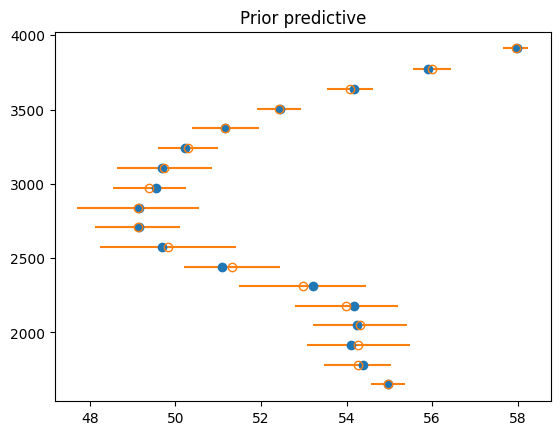

In [18]:
nu_mean = np.mean(nu_model, axis=0)
nu_sd = np.std(nu_model, axis=0)

plt.errorbar(nu%delta_nu.mean, nu, xerr=nu_err, fmt="o")
plt.errorbar(nu_mean%delta_nu.mean, nu_mean, xerr=nu_sd, fmt="o", markerfacecolor="none")

plt.title("Prior predictive")

In [19]:
nu_pred = jnp.linspace(nu.min(), nu.max(), 201)
dnu_pred = jax.vmap(model.glitch, in_axes=(axis, None))(prior_samples, nu_pred)
dnu_he_pred = jax.vmap(model.helium_glitch, in_axes=(axis, None))(prior_samples, nu_pred)
dnu_cz_pred = jax.vmap(model.bcz_glitch, in_axes=(axis, None))(prior_samples, nu_pred)

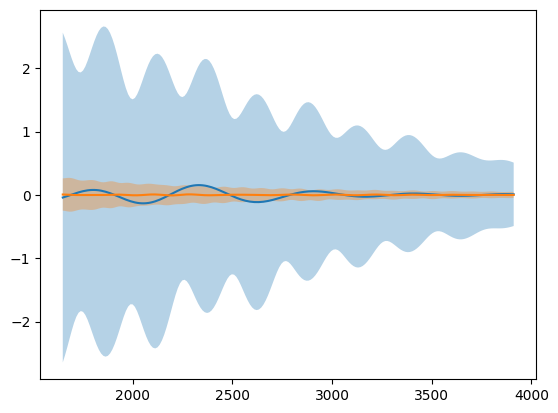

In [20]:
for d in [dnu_he_pred, dnu_cz_pred]:
    dnu_mean = d.mean(axis=0)
    dnu_sd = d.std(axis=0)

    plt.plot(
        nu_pred,
        dnu_mean,
    )

    plt.fill_between(nu_pred, dnu_mean-dnu_sd, dnu_mean+dnu_sd, alpha=0.33);

In [24]:
rstate = np.random.default_rng(0)
sampler = NestedSampler(model, nlive=500, sample="rwalk", walks=50, rstate=rstate)

In [26]:
results = sampler.run_nested()

13251it [02:17, 96.58it/s, +500 | bound: 157 | nc: 1 | ncall: 589140 | eff(%):  2.336 | loglstar:   -inf <  8.605 <    inf | logz: -17.394 +/-  0.234 | dlogz:  0.001 >  0.509]


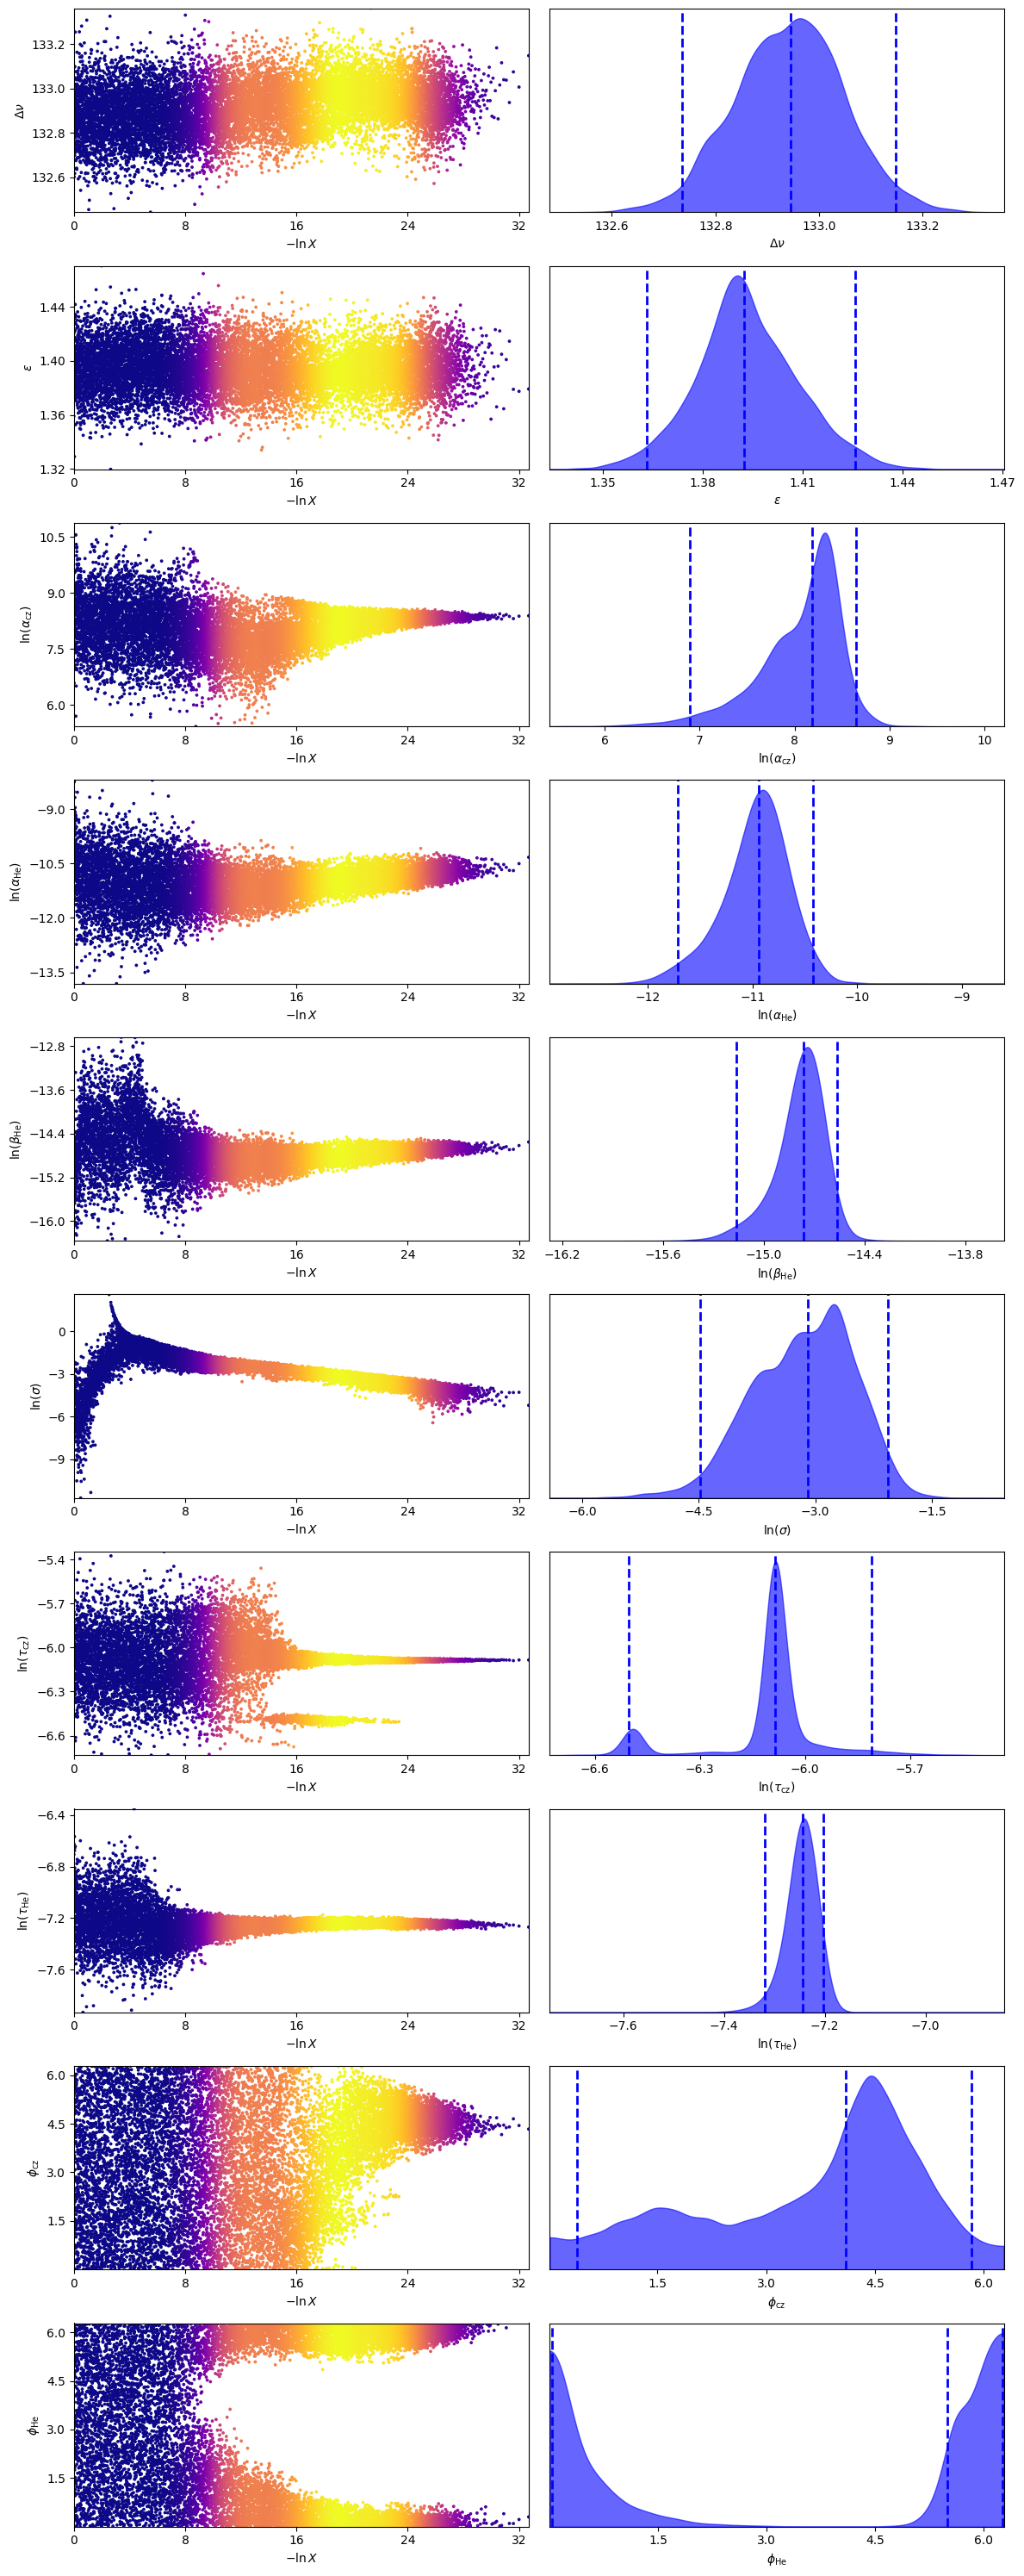

In [29]:
fig, axes = sampler.traceplot()
fig.tight_layout()

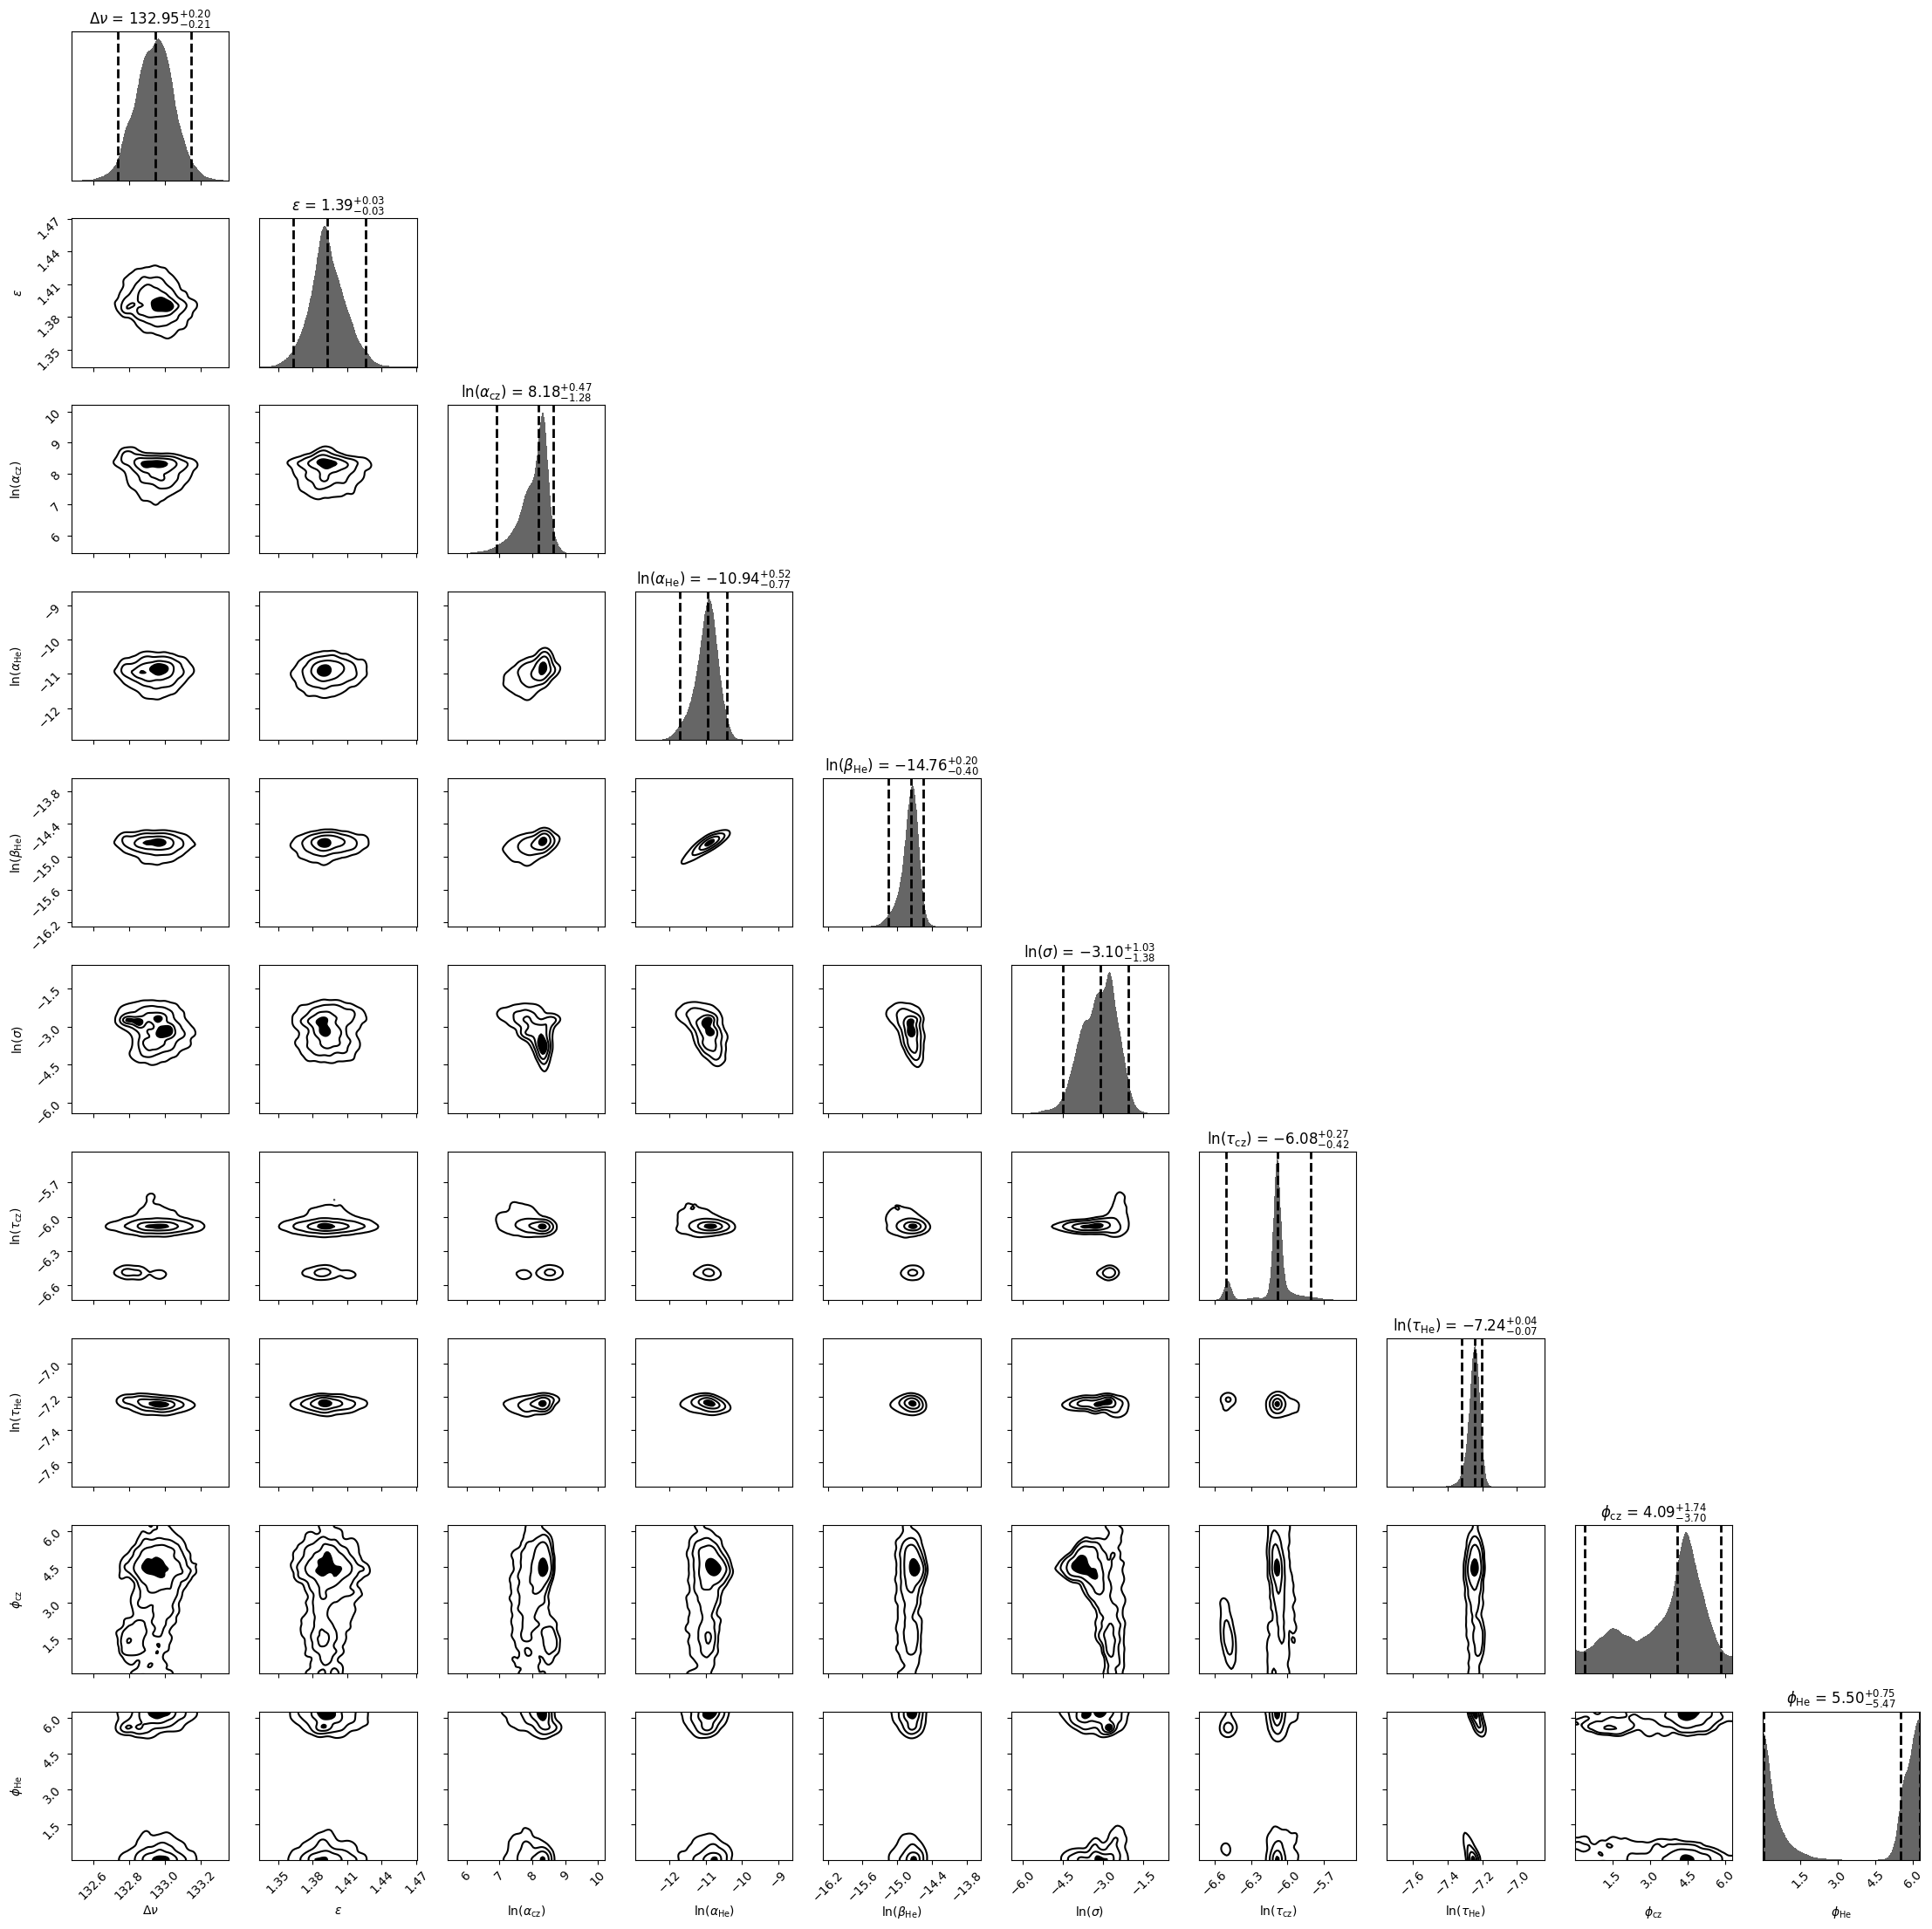

In [31]:
fig, axes = sampler.cornerplot(show_titles=True)
fig.tight_layout()

In [33]:
samples = sampler.resample(rstate=rstate)

In [115]:
def plot_glitch(model, samples, kind="both", intervals=None, draws=None, color=None, alpha=0.33, ax=None):
    if kind == "both":
        func = model.glitch
    elif kind == "he":
        func = model.helium_glitch
    elif kind == "cz":
        func = model.bcz_glitch
    else:
        raise ValueError(f"Kind '{kind}' is not one of ['both', 'he', 'cz'].")
    
    if ax is None:
        ax = plt.gca()
    
    properties = {"color": color}
    if color is None:
        properties.update(next(ax._get_lines.prop_cycler))
        
    nu_pred = jnp.linspace(model.nu.min(), model.nu.max(), 201)
    dnu_pred = jax.vmap(func, in_axes=(0, None))(samples, nu_pred)
    
    if draws is None:
        dnu_med = np.median(dnu_pred, axis=0)

        ax.plot(nu_pred, dnu_med, label=kind, **properties)
        
        if intervals is not None:
            # intervals is an iterable of two-tuples
            for interval in intervals:
                assert isinstance(interval, tuple)  # raise errors here
                assert len(interval) == 2
                dnu_lower, dnu_upper = np.quantile(dnu_pred, interval, axis=0)
                ax.fill_between(nu_pred, dnu_lower, dnu_upper, alpha=alpha, **properties)
    else:
        thin = samples["delta_nu"].shape[0] // draws + 1
        y = dnu_pred[::thin]
        x = jnp.broadcast_to(nu_pred, y.shape)
        ax.plot(x.T, y.T, alpha=alpha, **properties)
        
    return ax

In [127]:
def plot_echelle(key, model, samples, kind="full", intervals=None, draws=None, color=None, alpha=0.33, ax=None):
    if kind == "full":
        func = lambda params, n: model.sample(key, params, n)
    elif kind == "asy":
        func = model.smooth_component
    elif kind == "gp":
        func = lambda params, n: model.smooth_component(params, n) \
            + model.sample(key, params, n, include_mean=False) 
    else:
        raise ValueError(f"Kind '{kind}' is not one of ['full', 'asy', 'gp'].")

    delta_nu = samples["delta_nu"].mean()
    
    if model.nu_err is None:
        plt.plot(model.nu%delta_nu, model.nu, "o")
    else:
        plt.errorbar(model.nu%delta_nu, model.nu, xerr=model.nu_err, fmt="o")
    
    n_pred = jnp.linspace(model.n.min(), model.n.max(), 201)
    nu_pred = jax.vmap(func, in_axes=(0, None))(samples, n_pred)
    
    ax.plot((nu_pred - n_pred*delta_nu) % delta_nu, nu_pred)
    
    return ax


KeyboardInterrupt



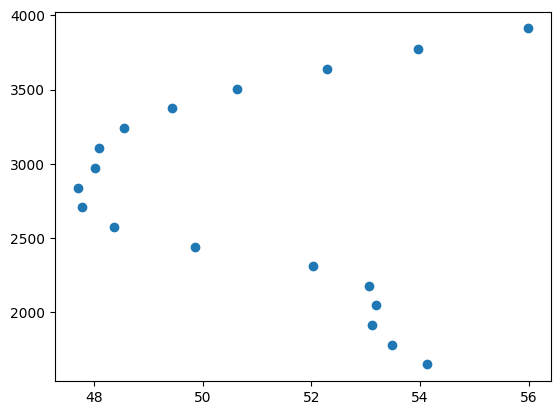

In [128]:
rng, key = random.split(rng)
ax = plot_echelle(key, model, samples)

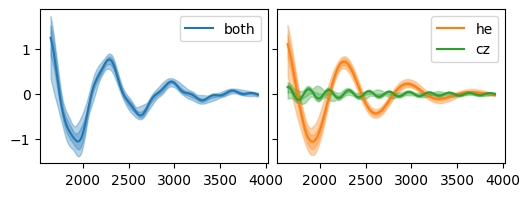

In [121]:
intervals = [(.16, .84), (.025, .975)]

fig, axes = plt.subplots(ncols=2, figsize=(6, 2), sharey=True, gridspec_kw={"wspace": 0.04})
ax0 = plot_glitch(model, samples, intervals=intervals, ax=axes[0])
ax0.legend()

ax1 = axes[1]

for i, kind in enumerate(["he", "cz"]):
    ax1 = plot_glitch(model, samples, kind=kind, intervals=intervals, color=f"C{i+1}", ax=ax1)
ax1.legend();

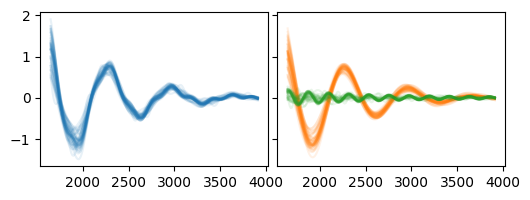

In [117]:
draws = 50
alpha = 0.1

fig, axes = plt.subplots(ncols=2, figsize=(6, 2), sharey=True, gridspec_kw={"wspace": 0.04})
ax0 = plot_glitch(model, samples, draws=draws, alpha=alpha, ax=axes[0])

ax1 = axes[1]

for i, kind in enumerate(["he", "cz"]):
    ax1 = plot_glitch(model, samples, kind=kind, draws=draws, color=f"C{i+1}", alpha=alpha, ax=ax1)

In [39]:
med = jax.tree_map(np.median, samples)
low = jax.tree_map(lambda x: np.quantile(x, .16), samples)
upp = jax.tree_map(lambda x: np.quantile(x, .84), samples)

In [40]:
def to_sec(log_tau):
    return 1e6*np.exp(log_tau)

Text(0, 0.5, 'density gradient')

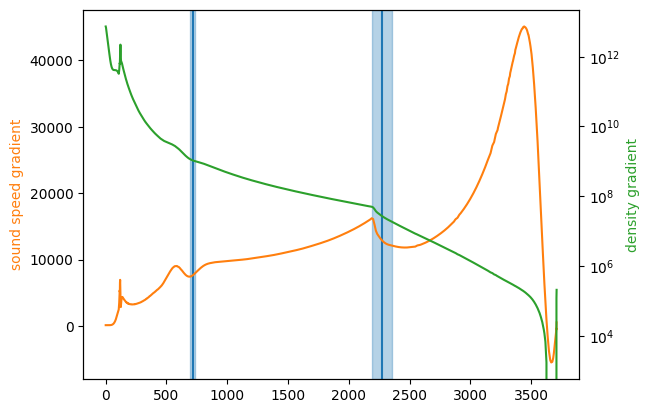

In [41]:
fig, ax = plt.subplots()


for g in ["he", "cz"]:
    ax.axvline(to_sec(med[f"log_tau_{g}"]), color="C0")
    ax.axvspan(to_sec(low[f"log_tau_{g}"]), to_sec(upp[f"log_tau_{g}"]), 
               color="C0", alpha=0.33)

ax.plot(data.tau, differentiate(data.cs, data.tau), color="C1")
ax.set_ylabel("sound speed gradient", color="C1")

ax = ax.twinx()

ax.plot(data.tau, differentiate(data.cs, data.rho), color="C2")
ax.set_yscale("log")
ax.set_ylabel("density gradient", color="C2")

In [43]:
gamma_he = 1e6*jnp.exp(samples["log_alpha_he"])
delta_he = 1e6*jnp.exp(0.5*samples["log_beta_he"])*jnp.sqrt(2)/4/np.pi  # width
tau_he = 1e6*jnp.exp(samples["log_tau_he"])  # location

In [44]:
dgamma_gamma = - gamma_he[:, None] * jax.vmap(norm.pdf, in_axes=(None, 0, 0))(data.tau.values, tau_he, delta_he)

In [45]:
dg_med = np.median(dgamma_gamma, axis=0)
dg_low, dg_upp = np.quantile(dgamma_gamma, [.16, .84], axis=0)

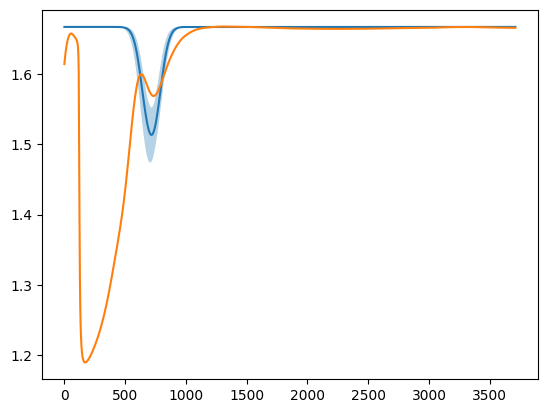

In [46]:
offset = 5/3
plt.plot(data.tau, offset+data.Gamma_1*dg_med)
plt.fill_between(data.tau, offset+data.Gamma_1*dg_low, offset+data.Gamma_1*dg_upp, alpha=0.33)
plt.plot(data.tau, data.Gamma_1)